In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.rc('font', **{'family': 'Microsoft YaHei, SimHei'})  # 设置中文字体的支持

# 提高输出效率库
from IPython.core.interactiveshell import InteractiveShell # 实现 notebook 的多行输出
InteractiveShell.ast_node_interactivity = 'all' #默认为'last'

## 课程首页分析
新改版的课程首页能使用户停留更久

    控制组(control)--旧页面
    实验组(experiment)--新页面
    这里假设浏览时长越长，用户对该页面就越感兴趣，注册的概率就更高

In [2]:
course = pd.read_csv('course_page_actions.csv')
course.info(); course.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4049 entries, 0 to 4048
Data columns (total 5 columns):
timestamp    4049 non-null object
id           4049 non-null int64
group        4049 non-null object
action       4049 non-null object
duration     4049 non-null float64
dtypes: float64(1), int64(1), object(3)
memory usage: 158.2+ KB


,timestamp,id,group,action,duration
1778,2016-11-15 07:32:58.885848,390050,control,enroll,117.806697
1535,2016-11-08 15:02:27.426684,800090,control,enroll,71.216541
3229,2016-12-25 14:21:57.792119,195894,control,view,105.340948
3992,2017-01-17 05:08:39.348050,319641,control,view,26.782571
3152,2016-12-23 14:13:18.496351,768470,experiment,view,129.817843


### 注册率分析

In [3]:
# 控制组注册率
control_enroll_num = course[ (course['group']=='control') & 
                         (course['action']=='enroll') ]['id'].nunique() 
control_view_num = course[ (course['group']=='control') & 
                         (course['action']=='view') ]['id'].nunique()
control_ctr = round((control_enroll_num*100 / control_view_num), 4)

print(f'控制组...')
control = {'注册数': control_enroll_num,
          '浏览数': control_view_num, 
          '注册率': str(control_ctr) + '%'}
print(control)

print('-'*45)

# 实验组注册率
exp_enroll_num = course[ (course['group']=='experiment') & 
                         (course['action']=='enroll') ]['id'].nunique() 
exp_view_num = course[ (course['group']=='experiment') & 
                         (course['action']=='view') ]['id'].nunique()
exp_ctr = round((exp_enroll_num*100 / exp_view_num), 4)

print(f'实验组...')
exp = {'注册数': exp_enroll_num,
          '浏览数': exp_view_num, 
          '注册率': str(exp_ctr) + '%'}
print(exp)

控制组...
{'注册数': 370, '浏览数': 1579, '注册率': '23.4326%'}
---------------------------------------------
实验组...
{'注册数': 439, '浏览数': 1645, '注册率': '26.6869%'}


### 浏览时长可视化

Text(0.5, 1.0, '实验组浏览时长分布')

Text(0.5, 1.0, '控制组浏览时长分布')

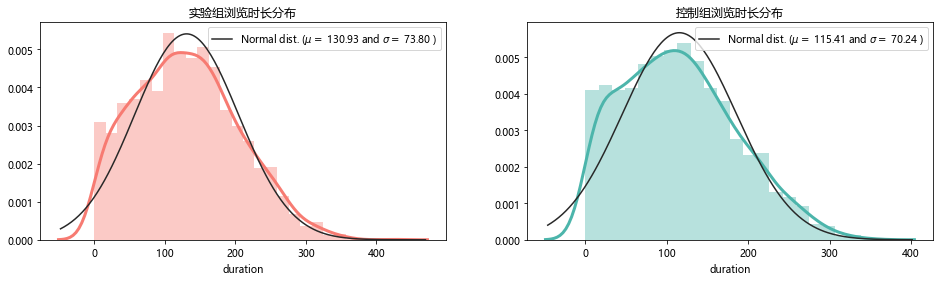

In [4]:
from scipy.stats import norm  # 用于拟合正态分布曲线

# 设置布局
fig = plt.figure(figsize=(16, 4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

exp_duration = course.query('group == "experiment"')['duration']
con_duration = course.query('group == "control"')['duration']

sns.distplot(exp_duration, fit=norm, color='#F77B72', 
             kde_kws={"color":'#F77B72', "lw":3 }, ax=ax1)
(mu, sigma) = norm.fit(exp_duration)  # 求同等条件下正态分布的 mu 和 sigma
# 添加图例：使用格式化输入，loc='best' 表示自动将图例放到最合适的位置
ax1.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'. \
           format(mu, sigma)] ,loc='best')

sns.distplot(con_duration, fit=norm, color='#4CB5AB', 
             kde_kws={"color": '#4CB5AB', "lw":3 }, ax=ax2)
(mu, sigma) = norm.fit(con_duration)  # 求同等条件下正态分布的 mu 和 sigma
# 添加图例：使用格式化输入，loc='best' 表示自动将图例放到最合适的位置
ax2.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'. \
           format(mu, sigma)] ,loc='best')

# 给子图添加标题
ax1.set_title('实验组浏览时长分布')
ax2.set_title('控制组浏览时长分布')

###### 结果分析
新界面的注册率有所提高，而浏览时长方面均呈现轻微的右偏，

实验组的浏览时长平均值比控制组高 15mins 左右，方差差别不大

可初步判断新改版的课程首页更吸引用户，后续将会进行假设检验来进一步验证我们的猜想

### 假设检验
我们将从控制组和实验组中各抽取一定数量的样本来进行假设检验

置信水平 α 的选择经验

    样本量      α-level
    ≤100        10%
    100＜n≤500   5%
    500＜n≤1000  1%
    n＞2000     千分之一

样本量过大，α-level 就没什么意义了。

使用分层抽样，Python 没有现成的库或函数，可以使用前人的轮子

In [5]:
from mysampling import get_sample

In [6]:
# df: 输入的数据框 pandas.dataframe 对象

# sampling:抽样方法 str
 ## 可选值有 ["simple_random", "stratified", "systematic"]
 ## 按顺序分别为: 简单随机抽样、分层抽样、系统抽样

# stratified_col: 需要分层的列名的列表 list，只有在分层抽样时才生效

# k: 抽样个数或抽样比例 int or float
    ## (int, 则必须大于0; float, 则必须在区间(0,1)中)
    ## 如果 0 < k < 1 , 则 k 表示抽样对于总体的比例
    ## 如果 k >= 1 , 则 k 表示抽样的个数；当为分层抽样时，代表每层的样本量

data = get_sample(df=course, sampling='stratified', 
                  stratified_col=['group'], k=300)
data.sample(4); data.info()

,timestamp,id,group,action,duration
3632,2017-01-07 05:45:38.833638,191559,experiment,view,262.290814
1317,2016-11-01 18:02:26.835997,586186,experiment,view,141.046177
3254,2016-12-26 10:14:33.868461,838969,control,view,131.325875
2354,2016-12-02 08:48:40.388294,310818,control,enroll,129.078949


<class 'pandas.core.frame.DataFrame'>
Int64Index: 600 entries, 1500 to 2533
Data columns (total 5 columns):
timestamp    600 non-null object
id           600 non-null object
group        600 non-null object
action       600 non-null object
duration     600 non-null float64
dtypes: float64(1), object(4)
memory usage: 28.1+ KB


In [7]:
# 总体未知，可采用两独立样本T检验
from scipy import stats

exp_duration = data.query('group == "experiment"')['duration']
con_duration = data.query('group == "control"')['duration']

print('两独立样本 T 检验...')
stats.ttest_ind(a=exp_duration, b=con_duration)
print('-'*45)
print('双样本 Z 检验...')
import statsmodels.  api as sm
sm.stats.ztest(x1=exp_duration, x2=con_duration)

两独立样本 T 检验...


Ttest_indResult(statistic=2.832720308119656, pvalue=0.004770921888179571)

---------------------------------------------
双样本 Z 检验...


(2.832720308119656, 0.0046153749817909205)